In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path
import random
import itertools

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split


import torch
from torch import nn

import warnings
warnings.filterwarnings("ignore")

In [2]:
# device = "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed = 42
set_seed(seed)

In [3]:
file_path = 'test_vegetation_indices_v2.csv'
val_data = pd.read_csv(file_path)
val_data.loc[val_data["Location"] == 'lincoln', 'Location'] = 'Lincoln'
val_data.loc[val_data["Location"] == 'movalley', 'Location'] = 'MOValley'
val_data['Year'] = [datetime.strptime(d, "%Y-%m-%d").year for d in val_data['Date']]
le = LabelEncoder()
val_data['Location_encoded'] = le.fit_transform(val_data['Location'])
len(val_data)

864

In [4]:
file_path = 'training_vegetation_indices_v2.csv'
data = pd.read_csv(file_path)
data.loc[data["Location"] == 'lincoln', 'Location'] = 'Lincoln'
data.loc[data["Location"] == 'movalley', 'Location'] = 'MOValley'
data['Year'] = [datetime.strptime(d, "%Y-%m-%d").year for d in data['Date']]
data['Location_encoded'] = le.fit_transform(data['Location'])

In [5]:
# Filtering Data / Data Cleaning
data = data.query("dap <= 110")
data = data.query("yieldPerAcre >= 100")

In [6]:
dropcols = ['Location','index','qrCode', 'irrigationProvided', 'nitrogenTreatment', 
            'plotLength', 'block', 'plotNumber', 'genotype', 'plantingDate', 
            'totalStandCount', 'daysToAnthesis', 'GDDToAnthesis','Row','Range','Experiment',
            'Imagename','Date','harvestingDate']
data_updated = data.drop(columns=dropcols)

dropcols1 = ['Location','irrigationProvided', 'qrCode', 'nitrogenTreatment',
             'plotLength','block','Row','Range','plotNumber','genotype','plantingDate',
             'totalStandCount','daysToAnthesis','GDDToAnthesis','Imagename','Experiment',
             'Date','harvestingDate']
val_updated = val_data.drop(columns=dropcols1)

In [7]:
data_updated.dropna(inplace=True)
len(data_updated)

5920

In [8]:
len(data_updated.columns)-1, data_updated.columns

(90,
 Index(['Red', 'Green', 'Blue', 'GLI', 'NGRDI', 'NDVI', 'GNDVI', 'SAVI', 'NDRE',
        'RedEdge', 'DeepBlue', 'Nir', 'DVI', 'GDVI', 'RDVI', 'TDVI', 'SCCI',
        'EVI', 'TVI', 'VARIG', 'GARI', 'GCI', 'GLI2', 'TGI', 'NLI', 'MNLI',
        'GSAVI', 'OSAVI', 'GOSAVI', 'MSAVI2', 'MSR', 'GRVI', 'WDRVI', 'SR',
        'BCC', 'BGI', 'BI', 'BRVI', 'CIVE', 'ExB', 'ExG', 'ExGR', 'ExR', 'GCC',
        'GR', 'HI', 'HUE', 'I_KAW', 'IOR', 'I_PCA', 'MGRVI', 'MPRI', 'MVARI',
        'NDI', 'NGBDI', 'RCC', 'RGBVI', 'PRI', 'SCI', 'SI', 'VARI', 'VDVI',
        'VEG', 'VIgreen', 'vNDVI', 'WI', 'poundsOfNitrogenPerAcre',
        'yieldPerAcre', 'daysToHarvest', 'dap', 'max_tmean', 'max_tmax',
        'max_tmin', 'max_par', 'max_rhum', 'min_tmean', 'min_tmax', 'min_tmin',
        'min_par', 'min_rhum', 'mean_tmean', 'mean_tmax', 'mean_par',
        'mean_rhum', 'sum_rain', 'n_tmax_abv30', 'n_tmin_blo10', 'wetdays',
        'gdd', 'Year', 'Location_encoded'],
       dtype='object'))

In [9]:
# Arranging features (X) and target (y)
X = data_updated.drop(columns='yieldPerAcre')
y = data_updated['yieldPerAcre'].to_frame(name='yieldPerAcre')

# Min Max Data Standardization
scalerX = MinMaxScaler()
columns = X.columns
X[columns] = scalerX.fit_transform(X)

scalerY = MinMaxScaler()
columns = y.columns
y[columns] = scalerY.fit_transform(y)

In [10]:
# Splitting training (95%) and testing data (5%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

print(f"Training set size: {len(X_train)} ({len(X_train)/len(X) * 100:.0f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X) * 100:.0f}%)")

X_train = torch.tensor(X_train.values).to(device).to(torch.float32)
y_train = torch.tensor(y_train.values.squeeze()).to(device).to(torch.float32)
X_test = torch.tensor(X_test.values).to(device).to(torch.float32)
y_test = torch.tensor(y_test.values.squeeze()).to(device).to(torch.float32)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Training set size: 5624 (95%)
Test set size: 296 (5%)


(torch.Size([5624, 90]),
 torch.Size([296, 90]),
 torch.Size([5624]),
 torch.Size([296]))

In [11]:
# Calculate accuracy
def get_r2(y_true, y_pred):
    return r2_score(y_true.to('cpu').detach().numpy(), y_pred.to('cpu').detach().numpy())

def get_rmse(y_true, y_pred):
    y_true_inverse = scalerY.inverse_transform(y_true.to('cpu').detach().numpy().reshape(1,-1))
    y_pred_inverse = scalerY.inverse_transform(y_pred.to('cpu').detach().numpy().reshape(1,-1))
    return mean_squared_error(y_true_inverse, y_pred_inverse)**0.5

In [12]:
# Dynamics Model
class MLP_Model(nn.Module):
    def __init__(self, input_features, output_features, hidden_unitsperLayer, dropout_rates):
        super(MLP_Model, self).__init__()

        all_neurons = [input_features] + \
            hidden_unitsperLayer + [output_features]
        layers = []

        for (i, o), dr in zip(itertools.pairwise(all_neurons), dropout_rates):
            layers.append(nn.Linear(in_features=i, out_features=o))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dr))

        self.linear_layer_stack = nn.Sequential(*layers)

    def forward(self, x):
        return self.linear_layer_stack(x)

In [13]:
model = MLP_Model(input_features=len(X.columns),
                  output_features=1,
                  hidden_unitsperLayer=[len(X.columns), 45, 2],
                  dropout_rates=[0.0, 0.0, 0.0, 0.0]).to(device)
model, next(model.parameters()).device

(MLP_Model(
   (linear_layer_stack): Sequential(
     (0): Linear(in_features=90, out_features=90, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.0, inplace=False)
     (3): Linear(in_features=90, out_features=45, bias=True)
     (4): ReLU()
     (5): Dropout(p=0.0, inplace=False)
     (6): Linear(in_features=45, out_features=2, bias=True)
     (7): ReLU()
     (8): Dropout(p=0.0, inplace=False)
     (9): Linear(in_features=2, out_features=1, bias=True)
     (10): ReLU()
     (11): Dropout(p=0.0, inplace=False)
   )
 ),
 device(type='cuda', index=0))

In [14]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.0001)

In [15]:
torch.manual_seed(42)

epochs = 6001
loss_list = []
for epoch in range(epochs):
    # Training
    model.train()

    y_pred = model(X_train).squeeze()                 # 1. Forward pass
    loss = loss_fn(y_pred, y_train)                   # 2. Calculate the loss
    loss_list.append(loss.item())                     #    Storing the loss
    train_r2 = get_r2(y_true=y_train, y_pred=y_pred)  #    Calculate the accuracy
    optimizer.zero_grad()                             # 3. Optimimzer zero grad
    loss.backward()                                   # 4. Perform backpropagation
    optimizer.step()                                  # 5. Optimizer step

    # Testing
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test).squeeze()

        test_loss = loss_fn(test_pred, y_test)
        test_r2 = get_r2(y_true=y_test, y_pred=test_pred)

    # Print Summary
    if (epoch) % 200 == 0:
        print('', end='\r')
        print(f'Epoch: {epoch:>5} | Loss: {loss:.5f}, Acc: {train_r2:5.2f} | ' +
            f'Test loss: {test_loss:.5f}, Test Acc: {test_r2:5.2f}')
    if train_r2.__round__(2) >= 0.49 and test_r2.__round__(2) >= .43:
        print(f'Epoch: {epoch:>5} | Loss: {loss:.5f}, Acc: {train_r2:5.2f} | ' +
              f'Test loss: {test_loss:.5f}, Test Acc: {test_r2:5.2f}')
        break

Epoch:     0 | Loss: 0.02713, Acc:  0.00 | Test loss: 0.02645, Test Acc:  0.01
Epoch:   200 | Loss: 0.02000, Acc:  0.26 | Test loss: 0.01944, Test Acc:  0.27
Epoch:   400 | Loss: 0.01764, Acc:  0.35 | Test loss: 0.01698, Test Acc:  0.36
Epoch:   600 | Loss: 0.01668, Acc:  0.39 | Test loss: 0.01624, Test Acc:  0.39
Epoch:   800 | Loss: 0.01606, Acc:  0.41 | Test loss: 0.01581, Test Acc:  0.41
Epoch:  1000 | Loss: 0.01566, Acc:  0.42 | Test loss: 0.01560, Test Acc:  0.41
Epoch:  1200 | Loss: 0.01536, Acc:  0.43 | Test loss: 0.01541, Test Acc:  0.42
Epoch:  1400 | Loss: 0.01510, Acc:  0.44 | Test loss: 0.01524, Test Acc:  0.43
Epoch:  1600 | Loss: 0.01490, Acc:  0.45 | Test loss: 0.01513, Test Acc:  0.43
Epoch:  1800 | Loss: 0.01476, Acc:  0.46 | Test loss: 0.01508, Test Acc:  0.43
Epoch:  2000 | Loss: 0.01468, Acc:  0.46 | Test loss: 0.01507, Test Acc:  0.43
Epoch:  2200 | Loss: 0.01461, Acc:  0.46 | Test loss: 0.01505, Test Acc:  0.43
Epoch:  2400 | Loss: 0.01455, Acc:  0.46 | Test loss

In [16]:
model.eval()
with torch.inference_mode():
    y_train_pred = model(X_train).squeeze()
    rmse_train = get_rmse(y_train, y_train_pred)
    r2_train = get_r2(y_train, y_train_pred)
    print(f"Training   : R² Score: {r2_train:.2f} | RMSE: {rmse_train:.2f}")

    y_test_pred = model(X_test).squeeze()
    rmse_test = get_rmse(y_test, y_test_pred)
    r2_test = get_r2(y_test, y_test_pred)
    print(f"Testing    : R² Score: {r2_test:.2f} | RMSE: {rmse_test:.2f}")

Training   : R² Score: 0.49 | RMSE: 21.08
Testing    : R² Score: 0.43 | RMSE: 21.95


#### Plotting regression plot for y_test vs y_pred

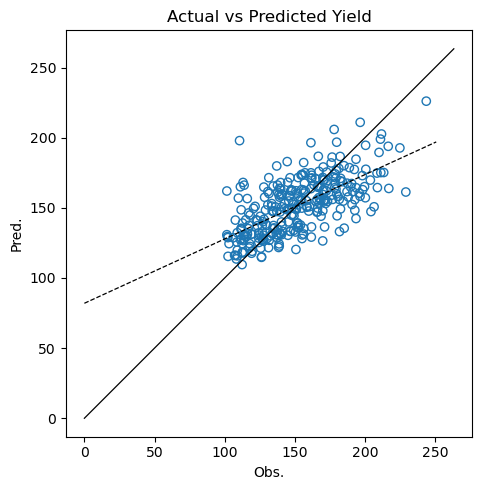

In [25]:
# Create a subset of the data for plotting
y_test_subset = scalerY.inverse_transform(y_test.to('cpu').detach().numpy().reshape(1, -1)).squeeze()
y_pred_subset = scalerY.inverse_transform(y_test_pred.to('cpu').detach().numpy().reshape(1, -1)).squeeze()

# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')

# Plot for actual values with markers and dashed line
ax.scatter(x=y_test_subset, y=y_pred_subset, facecolors='none', edgecolors='tab:blue')
slope, intercept = np.polyfit(y_test_subset, y_pred_subset, 1)
ax.plot(np.arange(0,ax.get_xlim()[-1],0.01), 
        slope*np.arange(0,ax.get_xlim()[-1],0.01)+intercept,
        color='black', linewidth=0.9, linestyle='--')
ax.plot(np.arange(0,ax.get_xlim()[-1],0.01),np.arange(0,ax.get_xlim()[-1],0.01),
        color='black',linewidth=0.9)

plt.xlabel('Obs.')
plt.ylabel('Pred.')

plt.title('Actual vs Predicted Yield')
plt.tight_layout()

plt.show()

#### Plotting first 70 points in y_test vs y_pred data

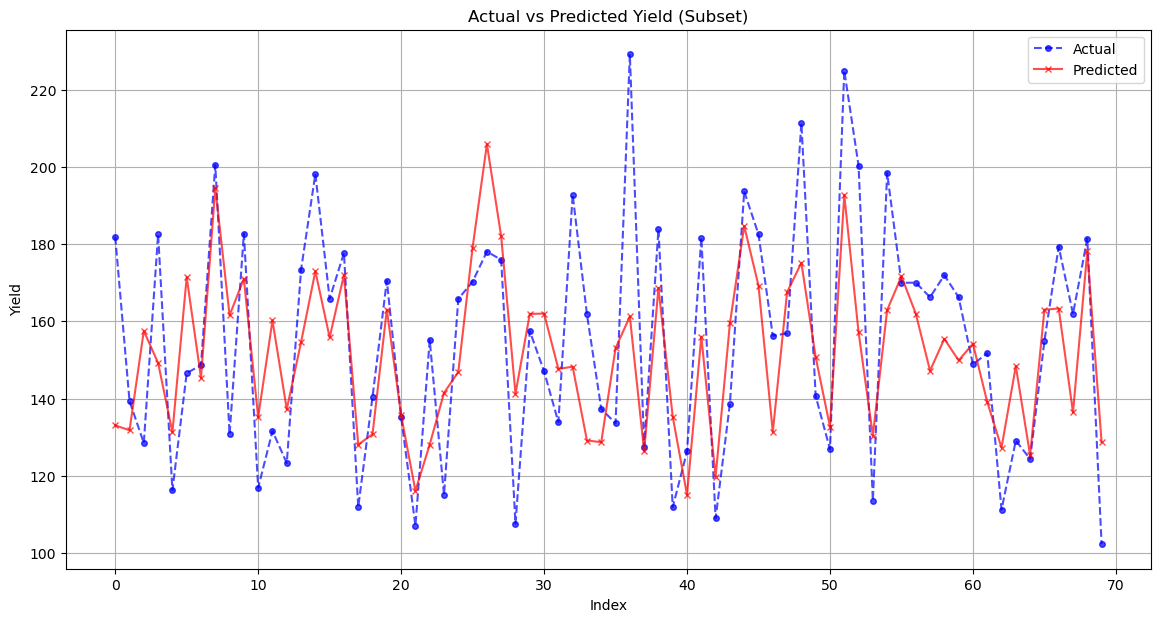

In [26]:
num_values_to_plot = 70  # Adjust this number based on how many points you want to see
 
# Create a subset of the data for plotting
y_test_subset = scalerY.inverse_transform(y_test.to('cpu').detach().numpy().reshape(1, -1)).squeeze()[:num_values_to_plot]
y_pred_subset = scalerY.inverse_transform(y_test_pred.to('cpu').detach().numpy().reshape(1, -1)).squeeze()[:num_values_to_plot]

# Plotting
plt.figure(figsize=(14, 7))
 
# Plot for actual values with markers and dashed line
plt.plot(y_test_subset, label='Actual', color='blue', linestyle='--', marker='o', markersize=4, alpha=0.7)
 
# Plot for predicted values with markers and solid line
plt.plot(y_pred_subset, label='Predicted', color='red', linestyle='-', marker='x', markersize=4, alpha=0.7)
 
plt.xlabel('Index')
plt.ylabel('Yield')
plt.title('Actual vs Predicted Yield (Subset)')
plt.legend()
plt.grid(True)
plt.show()
 

### Predicting on Test Data from Test Phase

In [27]:
X_final_test = val_updated.drop(columns='yieldPerAcre')
# y_final_test = val_updated['yieldPerAcre'].to_frame(name='yieldPerAcre')

columns = X_final_test.columns
X_final_test[columns] = scalerX.transform(X_final_test)

# columns = y_final_test.columns
# y_final_test[columns] = scalerY.transform(y_final_test)

X_final_test_tensor = torch.tensor(X_final_test.values).to(device).to(torch.float32)
# y_final_test_tensor = torch.tensor(y_final_test.values.squeeze()).to(device).to(torch.float32)

X_final_test_tensor.shape

torch.Size([864, 90])

In [28]:
model.eval()
with torch.inference_mode():
    y_final_test_pred = scalerY.inverse_transform(
        model(X_final_test_tensor).squeeze().to('cpu').detach().numpy().reshape(-1, 1))

    final_test_df = pd.DataFrame(X_final_test, columns=X_final_test.columns)
    final_test_df['yieldPerAcre'] = y_final_test_pred
    # final_test_df.to_csv("output_values_val.csv")

    final_test_df['Location'] = val_data.loc[final_test_df.index, 'Location'].values
    final_test_df['Row'] = val_data.loc[final_test_df.index, 'Row'].values
    final_test_df['Range'] = val_data.loc[final_test_df.index, 'Range'].values
    final_test_df['Experiment'] = val_data.loc[final_test_df.index, 'Experiment'].values

    grouped = final_test_df.groupby(
        ['Location', 'Row', 'Range', 'Experiment']).mean().reset_index()
    grouped.set_index(['Location', 'Row', 'Range', 'Experiment'], inplace=True)
    # grouped.to_csv("output_values_test.csv", index=False)

#### Checking Mean, Std, and Range of predicted values

In [29]:
grouped['yieldPerAcre'].mean(), grouped['yieldPerAcre'].std(
), grouped['yieldPerAcre'].max(), grouped['yieldPerAcre'].min()

(165.25732, 17.3925, 198.91472, 109.12672)

#### Organizing final predictions in required format/order

In [30]:
df_test_req = pd.read_csv("test_HIPS_HYBRIDS_2023_V2.3.csv")
df_test_req.set_index(['location', 'row', 'range', 'experiment'], inplace=True)

In [31]:
for location, range, row, experiment in df_test_req.index.values:
    df_test_req.loc[(location, range, row, experiment), 'yieldPerAcre'] = grouped.loc[(
        location, range, row, experiment), 'yieldPerAcre']

df_test_req['yieldPerAcre'].to_csv("final_submission_testphase.csv", index=False)

In [32]:
df_test_req[['yieldPerAcre', 'poundsOfNitrogenPerAcre']].groupby(
    ['poundsOfNitrogenPerAcre']).mean()

,yieldPerAcre
poundsOfNitrogenPerAcre,
75,163.368306
150,167.359602
225,164.143051
